In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
# from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.8.13 (default, Mar 28 2022, 06:13:39) 
[Clang 12.0.0 ]
Running on numpy v1.22.1


ModuleNotFoundError: No module named 'parameters'

Create Synthetic Rainbow + Transit

In [ ]:
# create polynomial + transit rainbow:

r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit:
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave))

# bin:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

rbin5.imshow_quantities();

## Fit with PyMC3 Transit Model

Create a transit model

In [ ]:
# create transit model:
t = TransitModel()

# add empty pymc3 model:
t.initialize_empty_model()

# add our parameters:
t.setup_parameters(
                  period=1, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05), # a value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = 1.0 # I will keep this fixed for when we add a polynomial model!
                )

# print a summary of all params:
t.summarize_parameters()

Now we can attach the data and setup the model!

In [20]:
# attach the Rainbow object to the model:
t.attach_data(rbin5)

# setup the lightcurves for the transit model:
t.setup_lightcurves()

# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82241.25it/s]


Let's check the model has the parameters we expect:

In [24]:
print(t.pymc3_model)

                epoch_interval__ ~ TransformedDistribution
       impact_parameter_impact__ ~ TransformedDistribution
       stellar_radius_interval__ ~ TransformedDistribution
         stellar_mass_interval__ ~ TransformedDistribution
limb_darkening_w0_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w0 ~ Normal
limb_darkening_w1_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w1 ~ Normal
limb_darkening_w2_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w2 ~ Normal
limb_darkening_w3_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w3 ~ Normal
limb_darkening_w4_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w4 ~ Normal
                           epoch ~ Uniform
                impact_parameter ~ ImpactParameter
                  stellar_radius ~ Uniform
                    stellar_mass ~ Uniform
               limb_darkening_w0 ~ QuadLimbDark
               limb_darkening_w

Now we can plot a couple of priors - do they look OK?


🌈 Warning: invalid value encountered in log

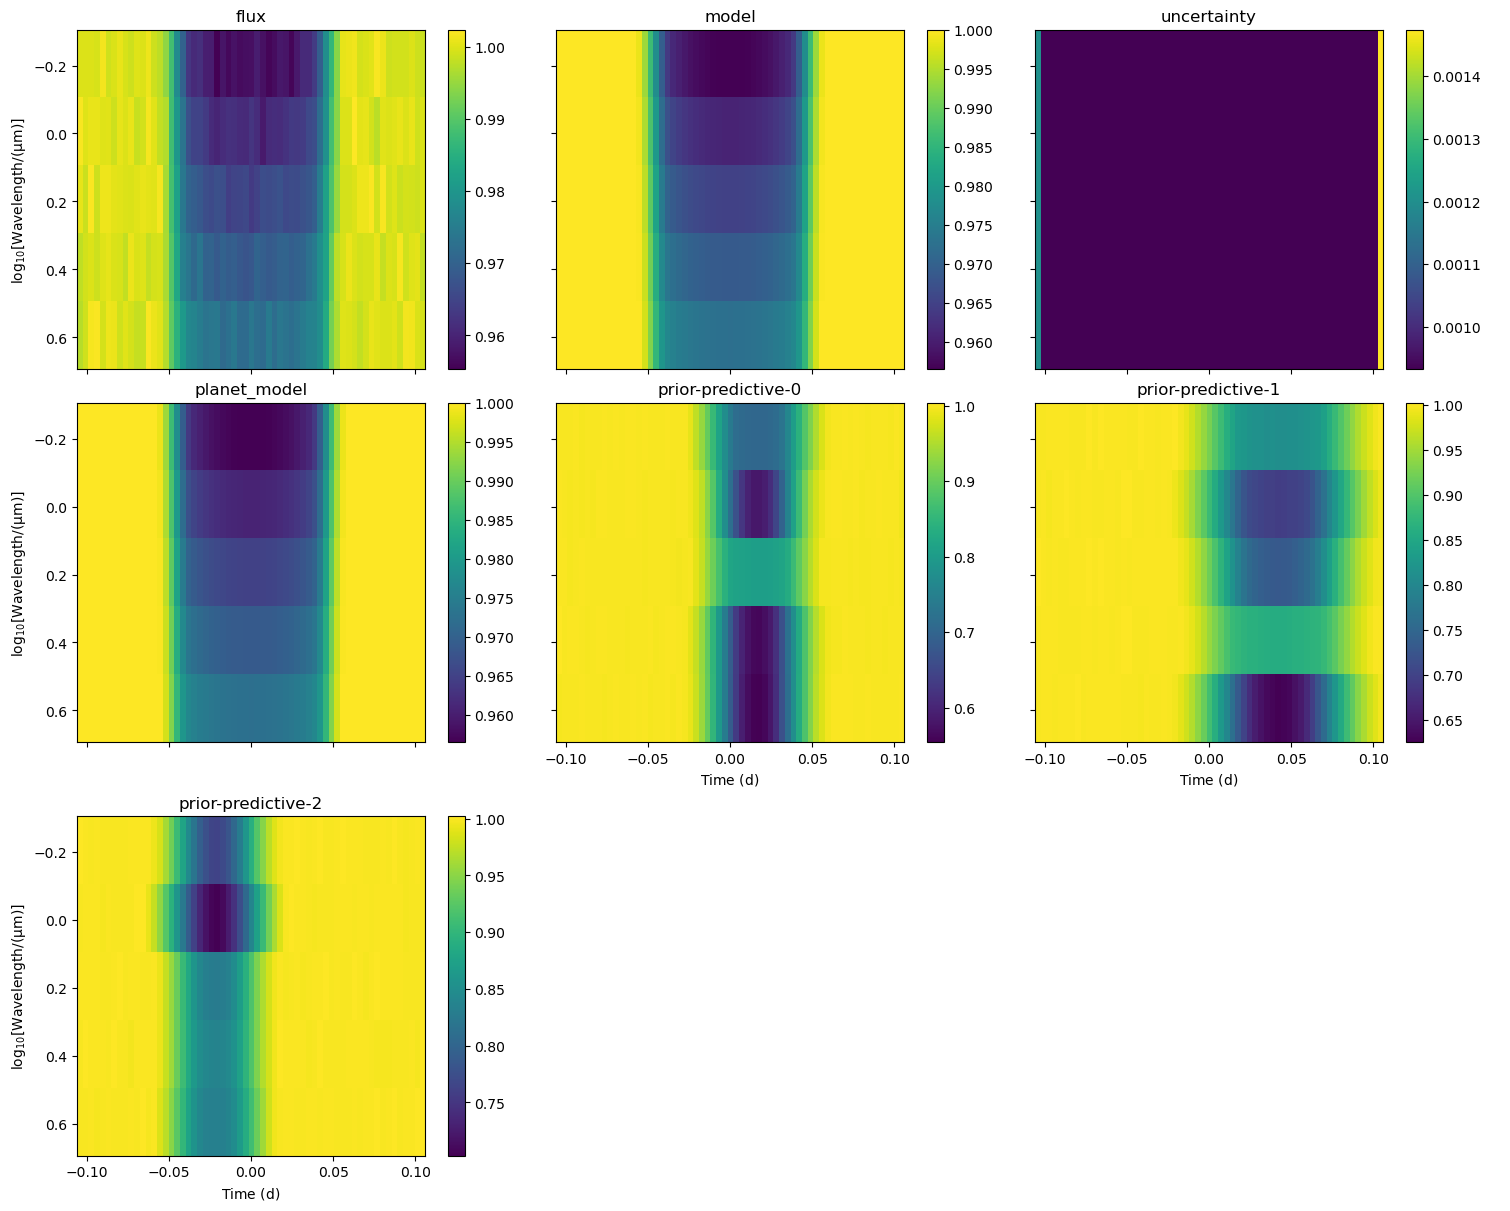

In [22]:
t.plot_priors()

Another check is does the orbit look good?

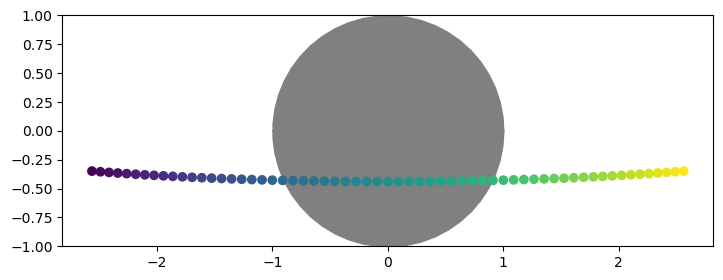

In [23]:
t.plot_orbit()

Finally, if we're happy, we can try sampling! This can take a while if there's lots of parameters!

In [25]:
t.sample(tune=3000, draws=3000, chains=4, cores=4)


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [radius_ratio_w4, limb_darkening_w4, radius_ratio_w3, limb_darkening_w3, radius_ratio_w2, limb_darkening_w2, radius_ratio_w1, limb_darkening_w1, radius_ratio_w0, limb_darkening_w0, stellar_mass, stellar_radius, impact_parameter, epoch]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 392 seconds.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


We might want to see a summary table of the MCMC sampling results:

In [26]:
t.summarize(round_to=7, fmt='wide')

                          mean        sd    hdi_3%   hdi_97%     mcse_mean  \
radius_ratio_w0       0.196025  0.001002  0.194135  0.197948  1.920000e-05   
radius_ratio_w1       0.186356  0.000966  0.184465  0.188160  2.350000e-05   
radius_ratio_w2       0.176473  0.000967  0.174619  0.178247  1.200000e-05   
radius_ratio_w3       0.166225  0.000949  0.164431  0.167978  1.330000e-05   
radius_ratio_w4       0.156292  0.000964  0.154506  0.158116  2.200000e-05   
epoch                 0.000030  0.000073 -0.000110  0.000166  7.000000e-07   
impact_parameter      0.081319  0.052436  0.000282  0.170554  7.491000e-04   
stellar_radius        1.178307  0.013489  1.156695  1.199980  3.826000e-04   
stellar_mass          0.849014  0.028869  0.800606  0.895223  6.031000e-04   
limb_darkening_w0[0]  0.116525  0.073325  0.000034  0.242108  1.117100e-03   
limb_darkening_w0[1]  0.413737  0.141679  0.148712  0.663132  2.100100e-03   
limb_darkening_w1[0]  0.213770  0.093793  0.034273  0.383832  1.

We might also want to see a couple of posterior samples as a "quick-look" check!


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

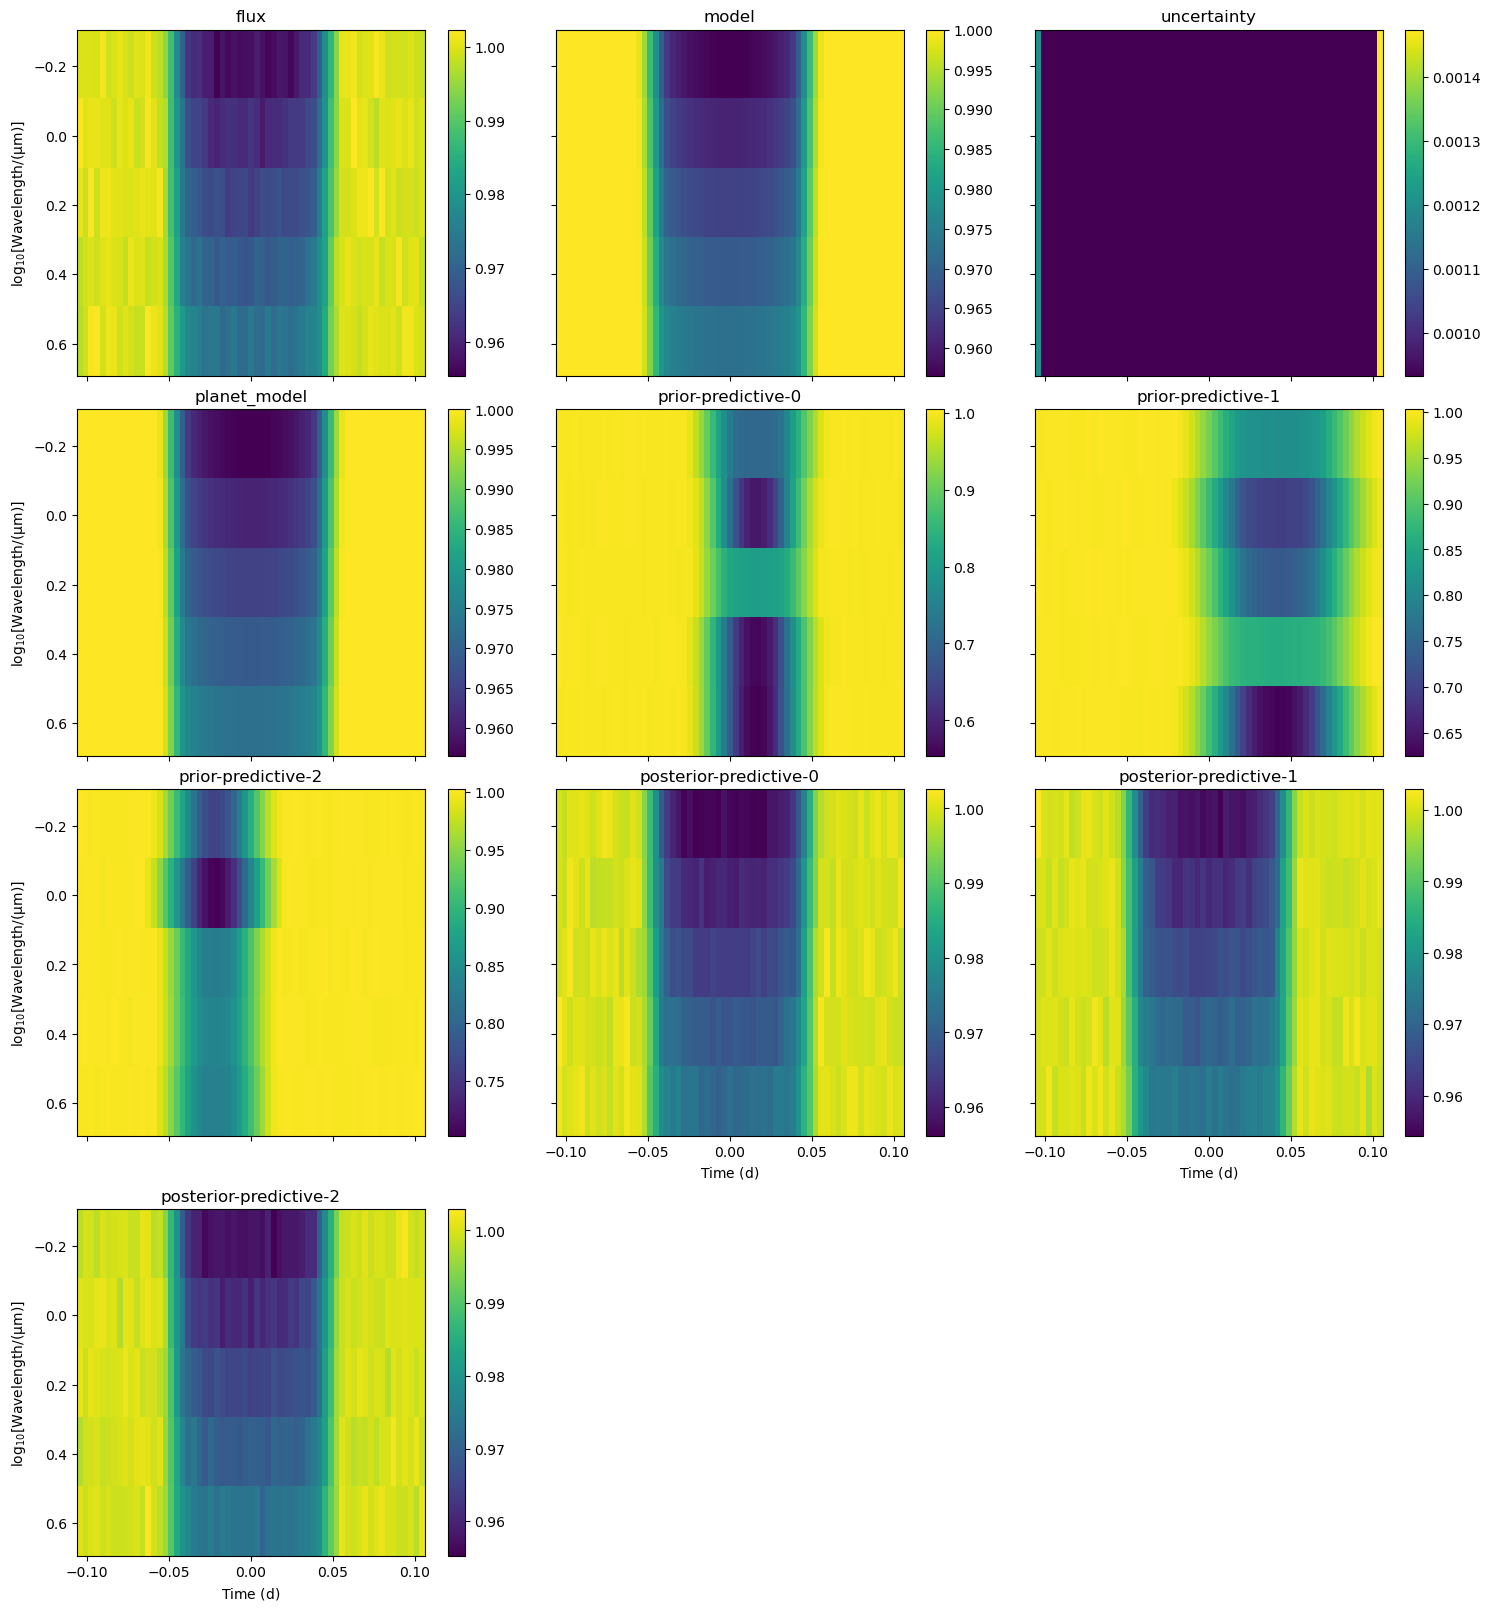

In [27]:
t.plot_posteriors()

## Add a polynomial!

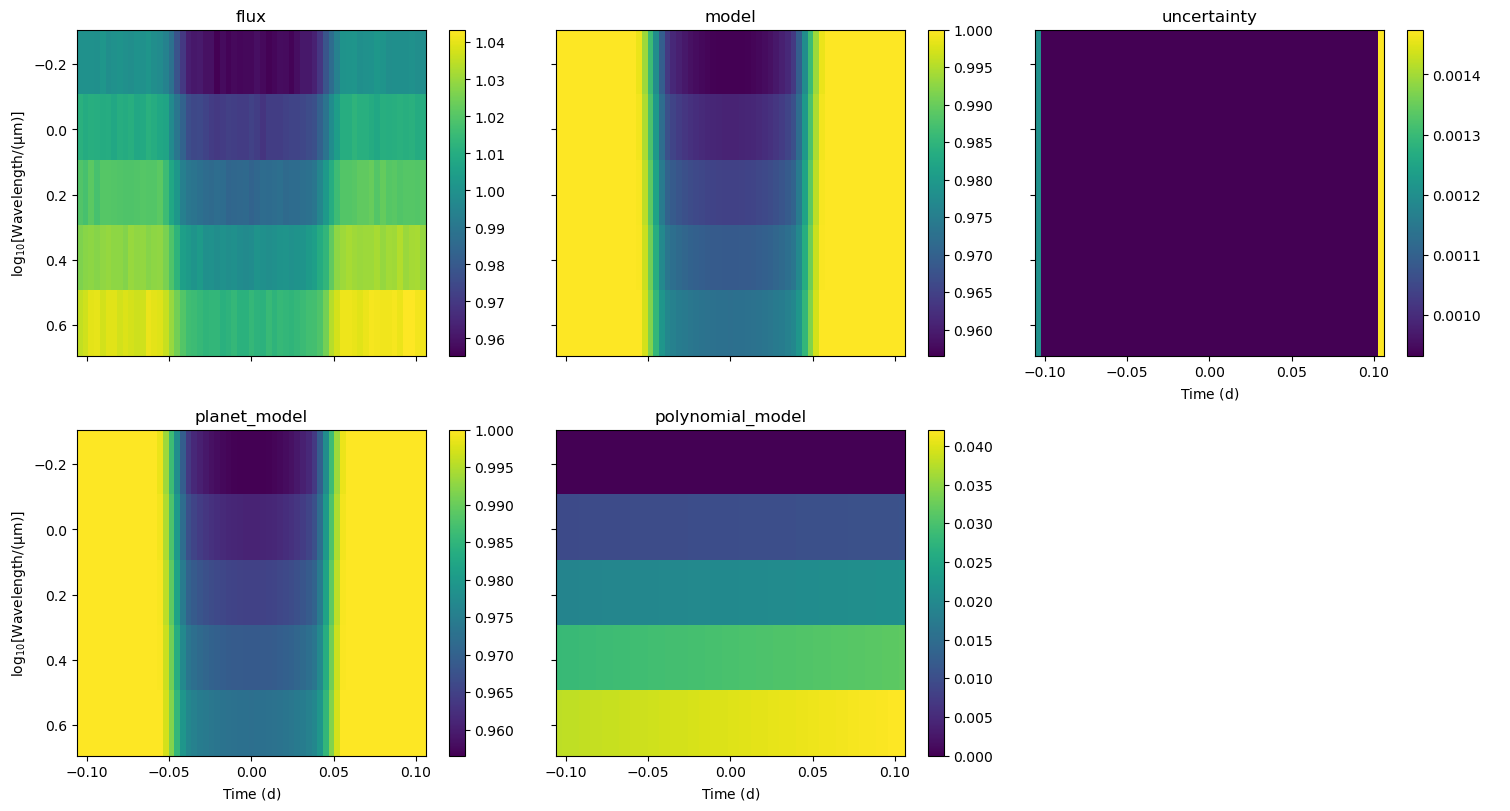

In [28]:
# create wavelength-dep linear + constant model:
poly = [(0.005*i*rbin5.time.to_value()) + (0.01*i) for i in range(rbin5.nwave)]

# add this model to the Rainbow
rp = rbin5._create_copy()
rp.flux = rp.flux + poly
rp.fluxlike['polynomial_model'] = np.array(poly)
rp.imshow_quantities();

Now we want to define a polynomial model:

In [29]:
# set up polynomial model:
b = PolynomialModel()
b.initialize_empty_model()
b.setup_parameters(
    p=WavelikeFitted(Uniform,testval=[0,0],upper=[0.1,0.1],lower=[-0.1,-0.1])
)

# we need to be careful (in this version!) with the baseline in the transit model and a constant term in the
# polynomial model - we don't want to have 2 fitted offset terms!

Combine the transit + polynomial models!

In [30]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()

# attach the models we want:
cm.attach_models({'transit':t,'polynomial':b})
# attach the new data
cm.attach_data(rp)

# setup model as before:
cm.setup_lightcurves()
cm.setup_likelihood()

100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 56073.58it/s]


Let's see the constituent models:

In [31]:
print(cm.chromatic_models)

{'transit': <experimental chromatic transit model 🌈>, 'polynomial': <experimental chromatic polynomial model 🌈>}


In [32]:
print(cm.pymc3_model)

                epoch_interval__ ~ TransformedDistribution
       impact_parameter_impact__ ~ TransformedDistribution
       stellar_radius_interval__ ~ TransformedDistribution
         stellar_mass_interval__ ~ TransformedDistribution
limb_darkening_w0_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w0 ~ Normal
limb_darkening_w1_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w1 ~ Normal
limb_darkening_w2_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w2 ~ Normal
limb_darkening_w3_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w3 ~ Normal
limb_darkening_w4_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w4 ~ Normal
                 p_w0_interval__ ~ TransformedDistribution
                 p_w1_interval__ ~ TransformedDistribution
                 p_w2_interval__ ~ TransformedDistribution
                 p_w3_interval__ ~ TransformedDistribution
                 p_w4_i

In [33]:
cm.sample(tune=3000, draws=3000, cores=4, chains=4)
cm.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_w4, p_w3, p_w2, p_w1, p_w0, radius_ratio_w4, limb_darkening_w4, radius_ratio_w3, limb_darkening_w3, radius_ratio_w2, limb_darkening_w2, radius_ratio_w1, limb_darkening_w1, radius_ratio_w0, limb_darkening_w0, stellar_mass, stellar_radius, impact_parameter, epoch]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 436 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


                          mean        sd    hdi_3%   hdi_97%     mcse_mean  \
radius_ratio_w0       0.195895  0.001143  0.193854  0.198135  1.650000e-05   
radius_ratio_w1       0.186786  0.001122  0.184608  0.188837  1.850000e-05   
radius_ratio_w2       0.177211  0.001123  0.175042  0.179230  1.760000e-05   
radius_ratio_w3       0.165120  0.001095  0.163119  0.167279  1.340000e-05   
radius_ratio_w4       0.156347  0.001142  0.154048  0.158379  1.500000e-05   
epoch                 0.000013  0.000078 -0.000131  0.000158  8.000000e-07   
impact_parameter      0.085024  0.056119  0.000108  0.181224  1.246800e-03   
stellar_radius        1.178462  0.013211  1.157213  1.199998  2.679000e-04   
stellar_mass          0.848546  0.028895  0.800076  0.895023  5.880000e-04   
limb_darkening_w0[0]  0.119370  0.072475  0.000507  0.243231  1.047700e-03   
limb_darkening_w0[1]  0.410950  0.141126  0.145335  0.657415  2.003400e-03   
limb_darkening_w1[0]  0.217534  0.093966  0.037501  0.386131  1.


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

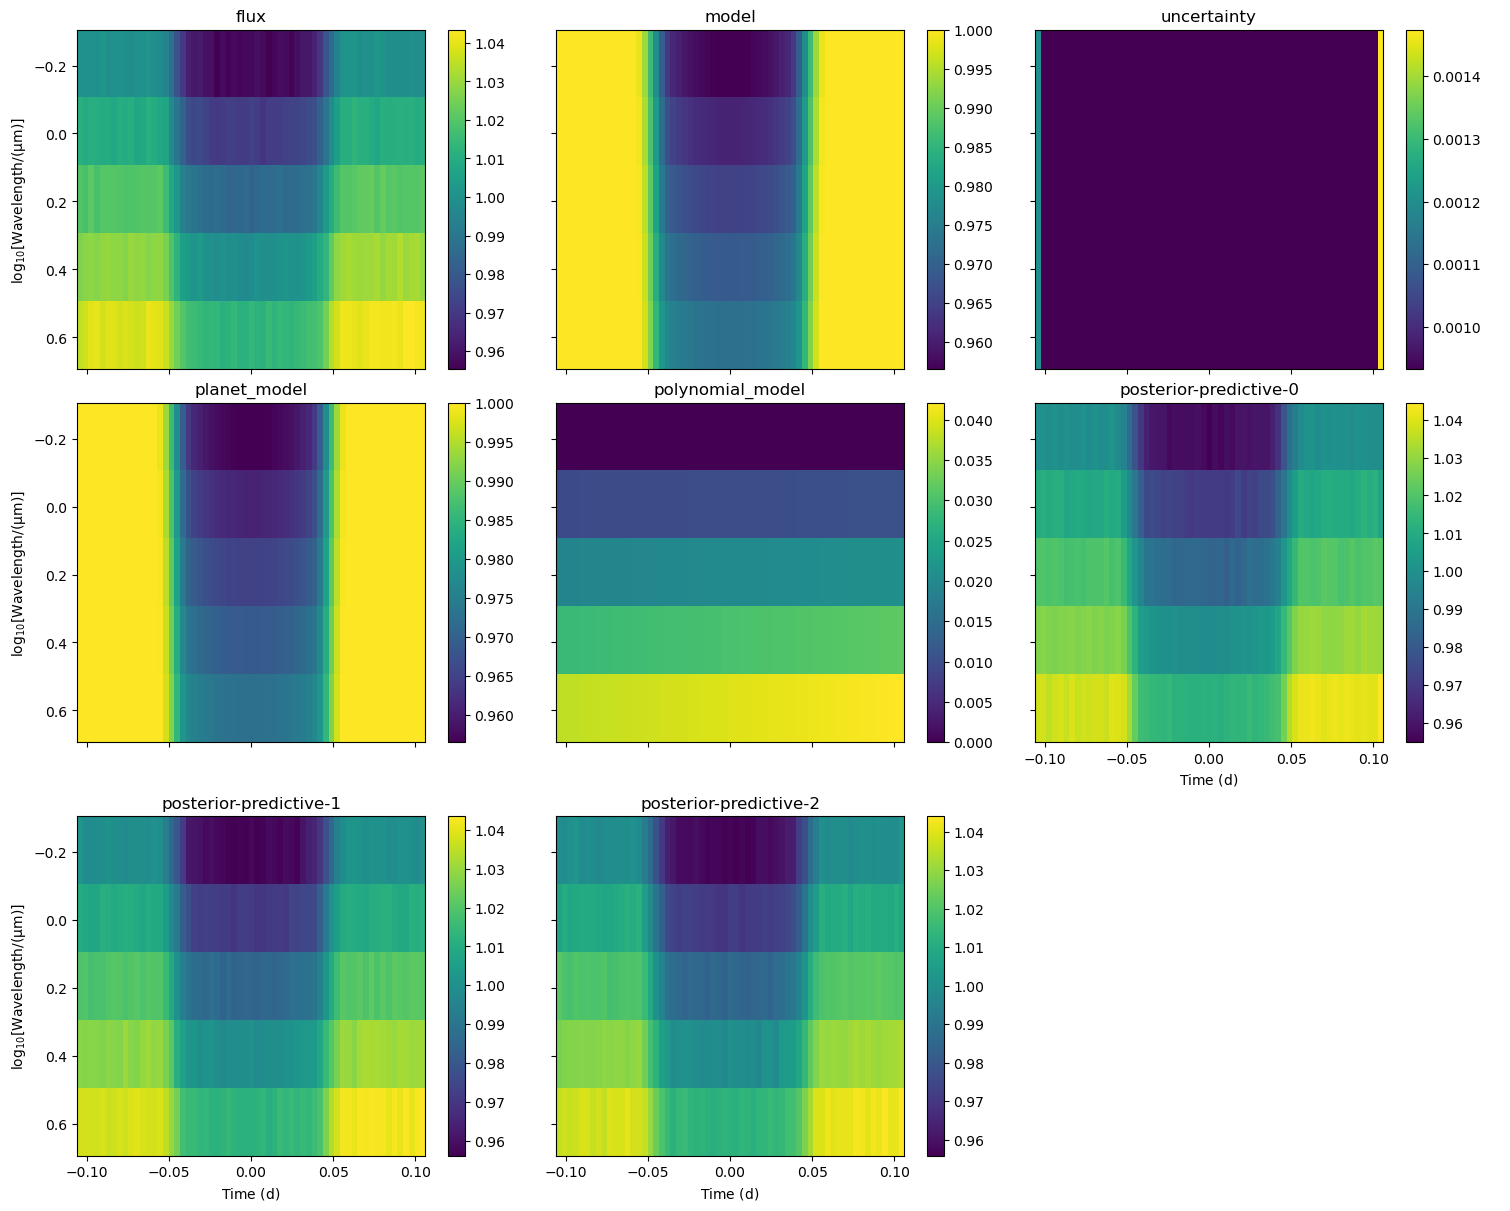

In [34]:
cm.plot_posteriors()

### Hopefully should look pretty good!

We can always subtract our polynomial model and look at what's left:

In [36]:
cm.data.fluxlike['residuals-0'] = cm.data.fluxlike['posterior-predictive-0'] - poly

We should just have the transit model now:

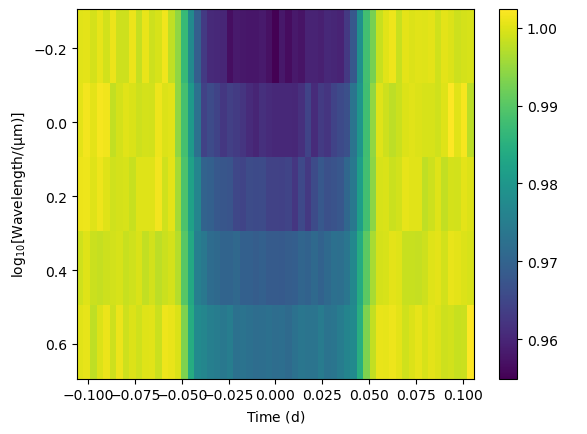

In [39]:
cm.data.imshow(quantity='residuals-0');

Subtracting the transit model (from chromatic defaults)

In [50]:
import batman

# Defaults for planet simulation.
defaults = {
        "t0": 0,
        "per": 3,
        "a": 10,
        "inc": 90,
        "ecc": 0,
        "w": 0,
        "limb_dark": "nonlinear",
        "u": [0.5, 0.1, 0.1, -0.1],
    }
    
# Initialize batman model.
params = batman.TransitParams()
params.t0 = defaults["t0"]
params.per = defaults["per"]
params.a = defaults["a"]
params.inc = defaults["inc"]
params.ecc = defaults["ecc"]
params.w = defaults["w"]
params.limb_dark = defaults["limb_dark"]
params.u = defaults["u"]

injected_radii = np.linspace(0.2, 0.15, rp.nwave)
planet_flux = np.zeros((rp.nwave, rp.ntime))
for i in range(rp.nwave):
    params.rp = injected_radii[i]

    m = batman.TransitModel(params, rp.time.to_value("day"))
    planet_flux[i] = m.light_curve(params)

In [54]:
cm.data.fluxlike['residuals-0'] = cm.data.fluxlike['residuals-0'] - planet_flux

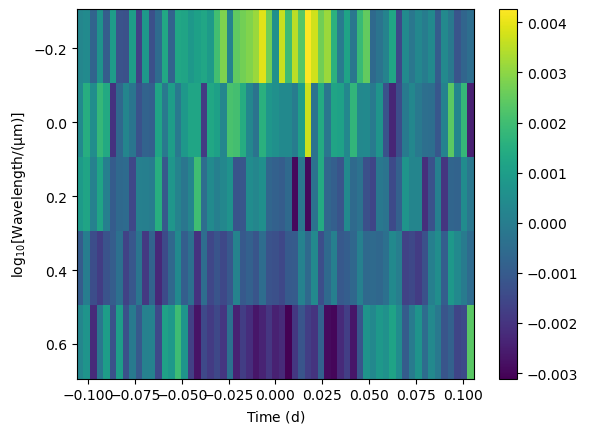

In [55]:
cm.data.imshow(quantity='residuals-0');